In [1]:
from config import setup, import_and_display_fnc

setup()

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix,
    symbolic_eval,
    build_interp_matrix,
    build_interpolator,
    qbx_setup,
    double_layer_matrix,
    stage1_refine, qbx_panel_setup, stage2_refine
)

In [116]:
corner_resolution = 0.5
fault_top = 0.0
surf_half_L = 100

qx, qw = gauss_rule(6)
t = sp.var("t")


control_points = np.array([(0, 0, 2, corner_resolution)])
fault = stage1_refine((t, t * 0, fault_top + (t + 1) * -0.5), (qx, qw), control_points=control_points)
flat = stage1_refine(
    (t, -t * surf_half_L, 0 * t), (qx, qw), other_surfaces=[fault], control_points=control_points
)

done after n_iterations=2 with n_panels=4
done after n_iterations=10 with n_panels=26


In [108]:
#kappas = [1, 2, 3, 5, 10]
#for kp in kappas:
ps = [7,10]
As = []
A_raws = []
Bs = []
solns = []
kp = 4
for p in ps:
    expansions = qbx_panel_setup(flat, other_surfaces=[fault], direction=1, p=p)
    fault_stage2, fault_interp_mat = stage2_refine(fault, expansions, kappa=kp)
    flat_stage2, flat_interp_mat = stage2_refine(flat, expansions, kappa=kp)
    A_raw = qbx_matrix(double_layer_matrix, flat_stage2, flat.pts, expansions)[:, 0, :]
    A = A_raw.dot(flat_interp_mat.toarray())
    A_raws.append(A_raw)
    As.append(A)
    B = -qbx_matrix(double_layer_matrix, fault_stage2, flat.pts, expansions)[:, 0, :]
    Bs.append(B.dot(fault_interp_mat.toarray()))
    
    lhs = np.eye(A.shape[0]) + A
    rhs = B.dot(np.ones(fault_stage2.n_pts))
    surf_disp = np.linalg.solve(lhs, rhs)
    solns.append(surf_disp)

KeyboardInterrupt: 

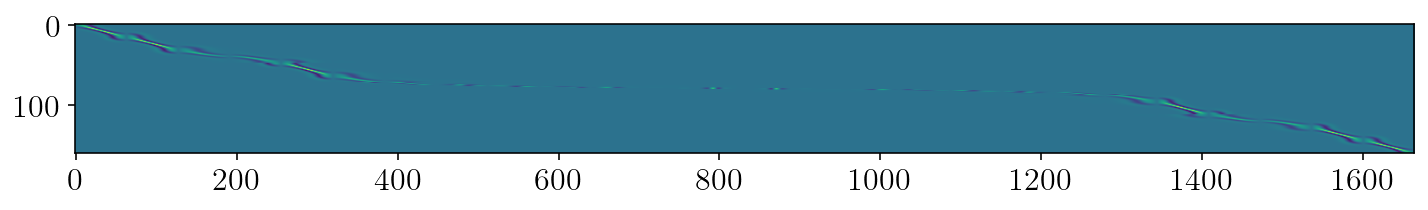

In [96]:
plt.figure(figsize=(12,12))
plt.imshow(A_raws[-2] - A_raws[-1])
plt.show()

In [97]:
np.max(np.abs(As[-2] - As[-1]))

0.09493500732984061

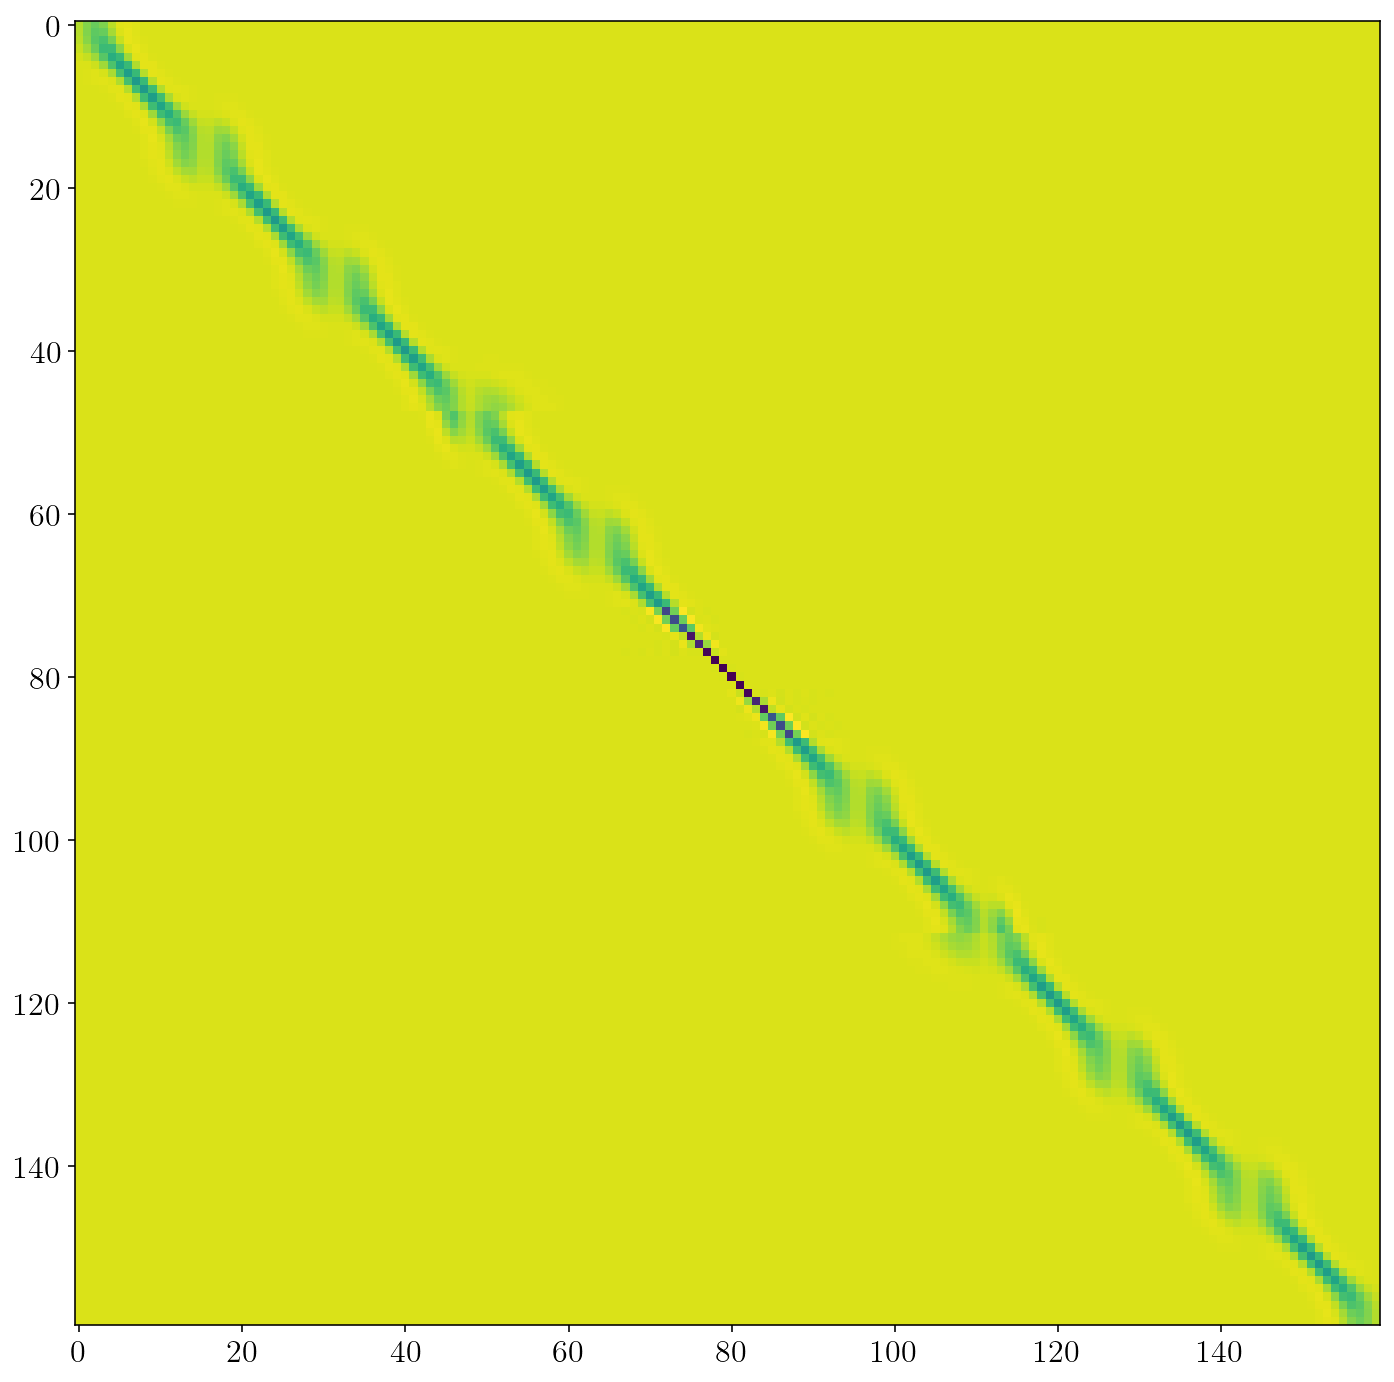

In [98]:
plt.figure(figsize=(12,12))
plt.imshow(As[-2])
plt.show()

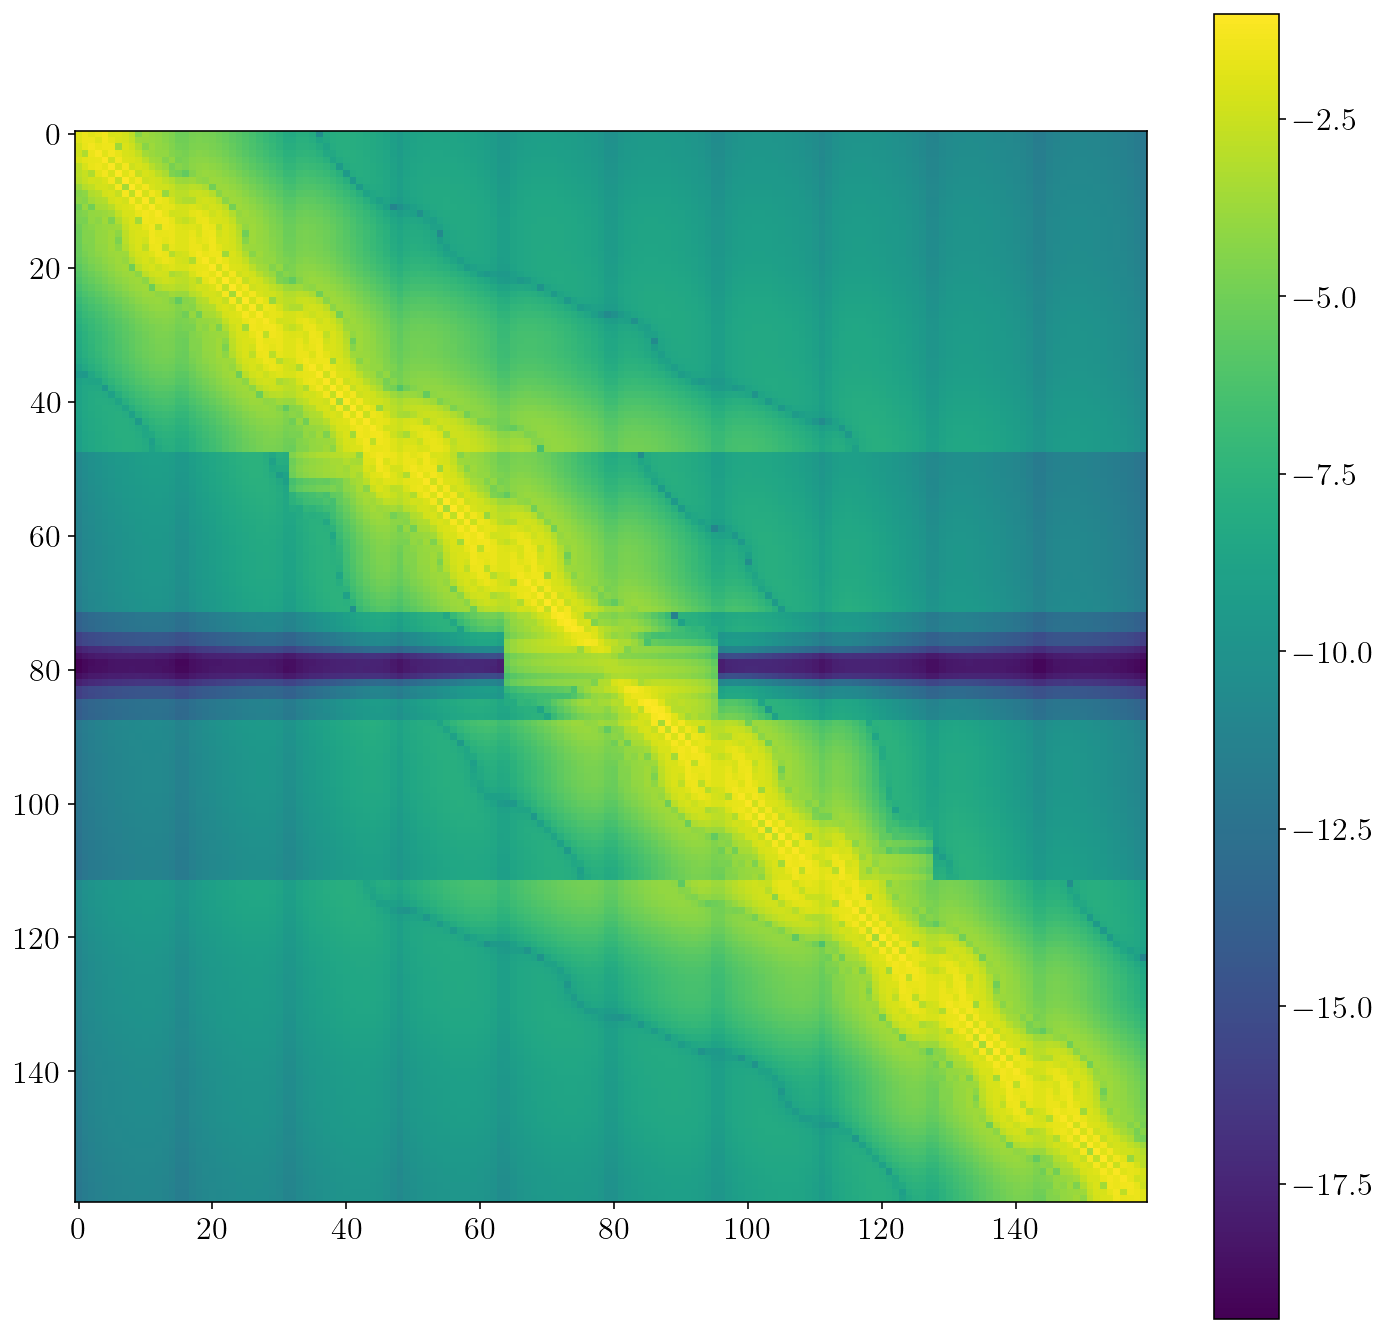

In [99]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(np.abs(As[-2] - As[-1])))
plt.colorbar()
plt.show()

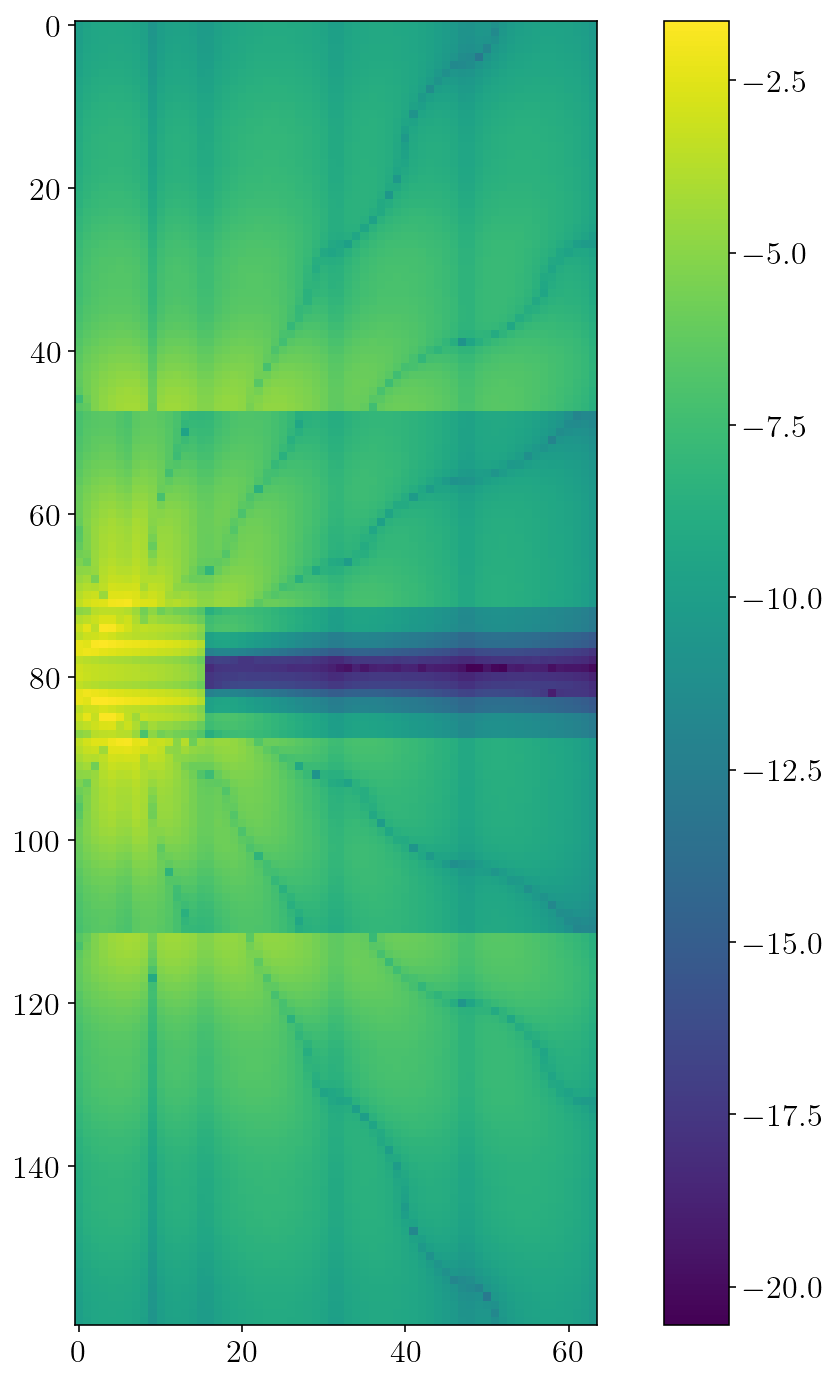

In [100]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(np.abs(Bs[-2] - Bs[-1])))
plt.colorbar()
plt.show()

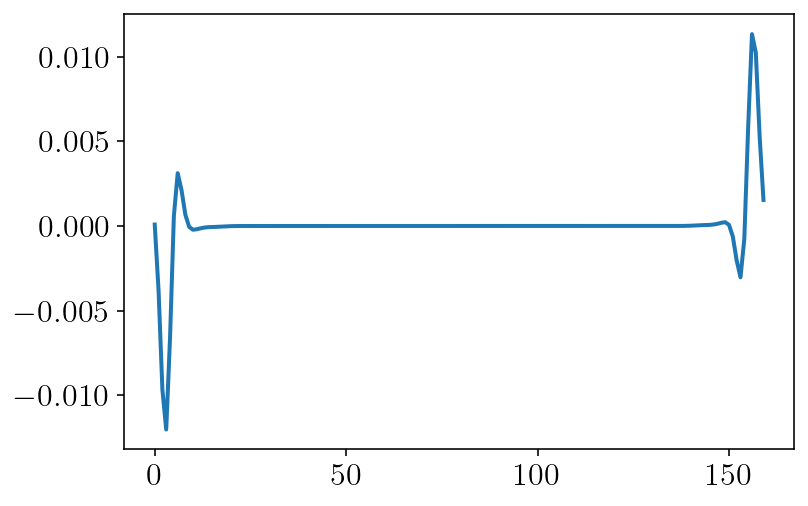

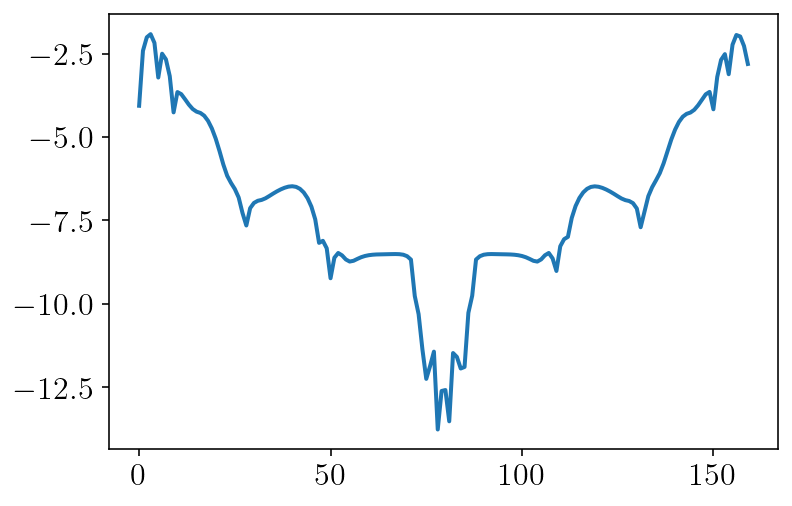

In [101]:
plt.plot(solns[-2] - solns[-1])
plt.show()
plt.plot(np.log10(np.abs(solns[-2] - solns[-1])))
plt.show()

In [102]:
print('\nA')
for i in range(len(As)):
    print(np.max(np.abs(As[i] - As[-1])))
    
print('\nB')
for i in range(len(Bs)):
    print(np.max(np.abs(Bs[i] - Bs[-1])))

print('\nsoln')
for i in range(len(solns)):
    print(np.max(np.abs(solns[i] - solns[-1])))


A
0.09493500732984061
0.0

B
0.023171711852176872
0.0

soln
0.012017856463626048
0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

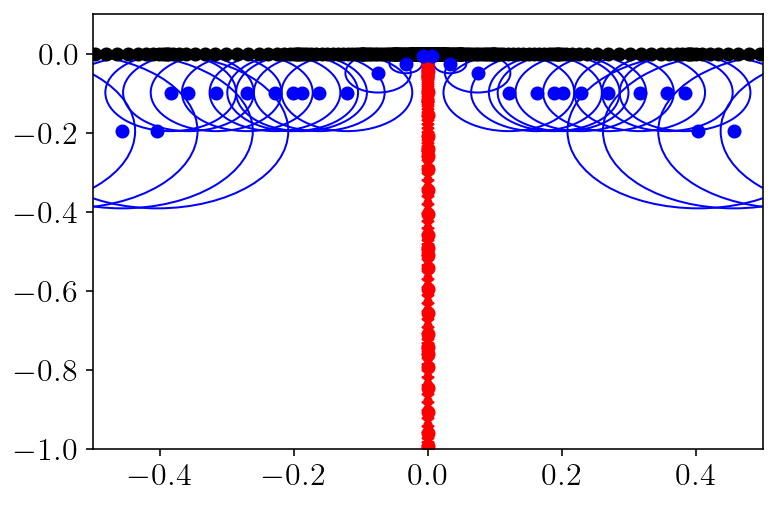

In [117]:
expansions = qbx_panel_setup(flat, other_surfaces=[fault], direction=1, p=10)
fault_stage2, fault_interp_mat = stage2_refine(fault, expansions)
flat_stage2, flat_interp_mat = stage2_refine(flat, expansions)

%matplotlib widget
plt.figure()
plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-o')
plt.plot(fault_stage2.pts[:,0], fault_stage2.pts[:,1], 'r*')
plt.plot(flat_stage2.pts[:,0], flat_stage2.pts[:,1], 'k-o')
plt.plot(expansions.pts[:,0], expansions.pts[:,1], 'bo')
for i in range(expansions.N):
    plt.gca().add_patch(plt.Circle(expansions.pts[i], expansions.r[i], color='b', fill=False))
plt.xlim([-0.5,0.5])
plt.ylim([-1, 0.1])
plt.show()

In [118]:
%matplotlib inline

number of points in the free surface discretization: 156
       number of points in the fault discretization: 24
number of points in the free surface quadrature: 900
       number of points in the fault quadrature: 162


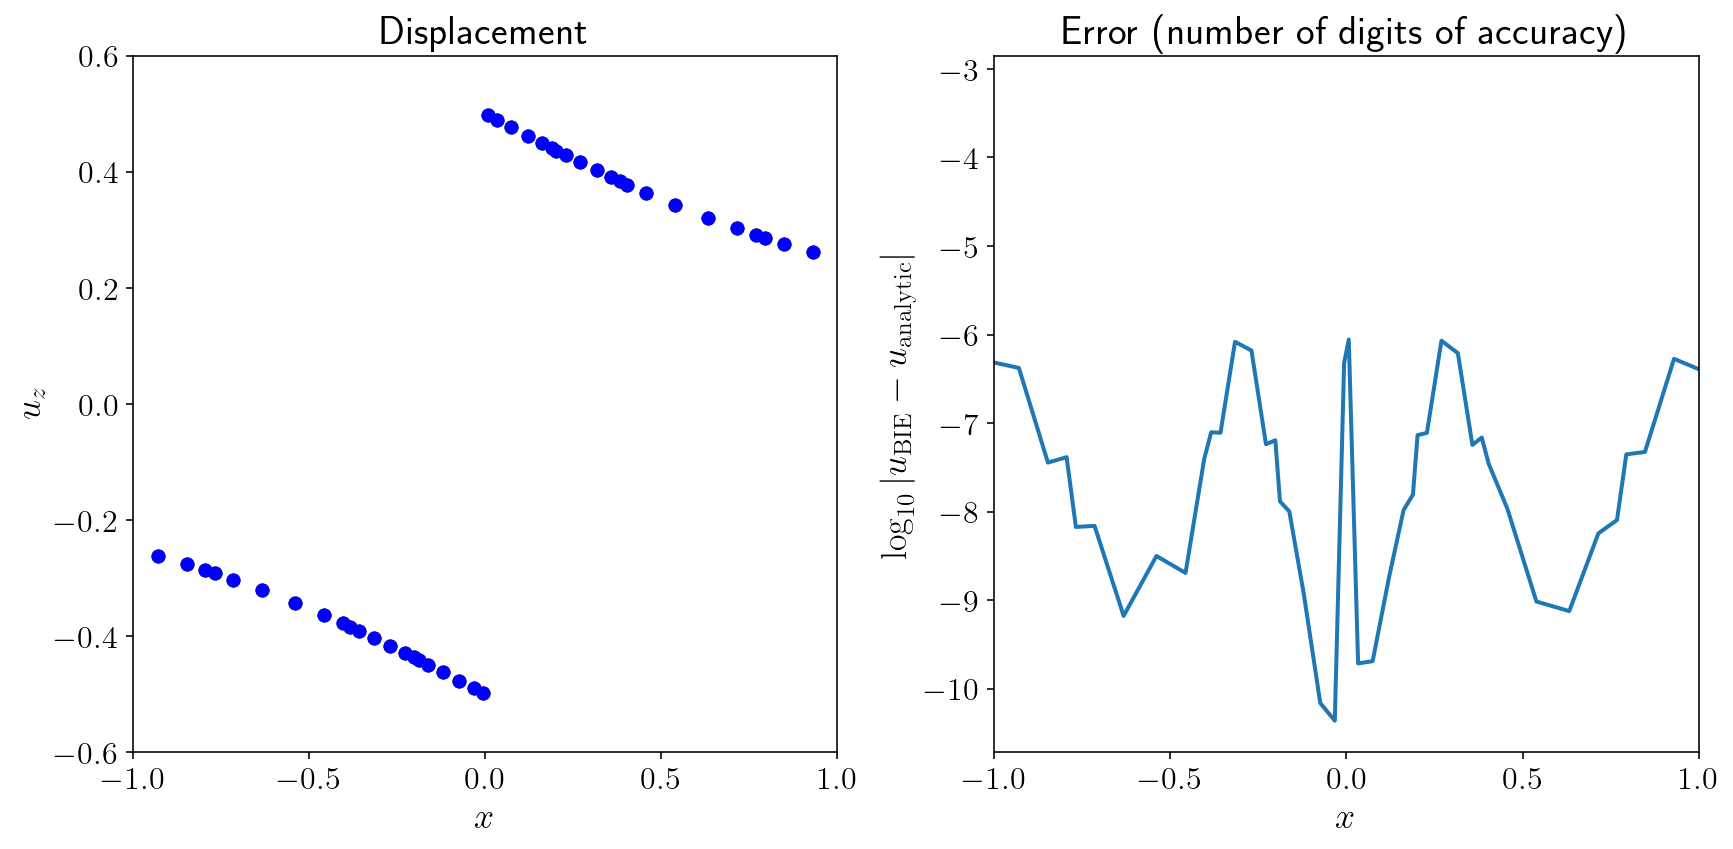

In [119]:
# plt.plot(np.log10(np.abs(flat.pts[:,0])))
# plt.xlabel(r'$i$')
# plt.ylabel(r'$\log_{10}(|x|)$')

plt.show()

print('number of points in the free surface discretization:', flat.n_pts)
print('       number of points in the fault discretization:', fault.n_pts)
print('number of points in the free surface quadrature:', flat_stage2.n_pts)
print('       number of points in the fault quadrature:', fault_stage2.n_pts)

A_raw = qbx_matrix(double_layer_matrix, flat_stage2, flat.pts, expansions)[:, 0, :]

A_raw.shape, flat_interp_mat.shape

A = A_raw.dot(flat_interp_mat.toarray())

B = -qbx_matrix(double_layer_matrix, fault_stage2, flat.pts, expansions)[:, 0, :]

lhs = np.eye(A.shape[0]) + A
rhs = B.dot(np.ones(fault_stage2.n_pts))
surf_disp = np.linalg.solve(lhs, rhs)

# Note that the analytical solution is slightly different than in the buried 
# fault setting because we need to take the limit of an arctan as the 
# denominator of the argument  goes to zero.
s = 1.0
analytical = -np.arctan(-1 / flat.pts[:,0]) / np.pi

for XV in [1.0]:#, 10.0]:#, 1000.0]:
    # XV = 5 * corner_resolution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(flat.pts[:, 0], surf_disp, "ko")
    plt.plot(flat.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    plt.plot(flat.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel(r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()